In [1]:
%load_ext autoreload
%autoreload 2

import sys, pathlib
sys.path.insert(0, str(pathlib.Path.cwd().parent))

# import opensim as osim
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from src.data_utils import *
from src.transformer import TransformerModel
from src.training_utils import *

### Load segmented data

In [2]:
# define data directory
data_dir = '../data/'

In [3]:
# load data
data = load_data(data_dir)

# split data
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data)

Number of samples: 13388
--------------------
Train data shape: (10710, 100, 12)
Validation data shape: (1338, 100, 12)
Test data shape: (1340, 100, 12)
--------------------
X_train shape: (10710, 100, 3)
y_train shape: (10710, 100, 9)
X_val shape: (1338, 100, 3)
y_val shape: (1338, 100, 9)
X_test shape: (1340, 100, 3)
y_test shape: (1340, 100, 9)


(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Achilles Tendon Force Across Training Samples'}, xlabel='Percent Normalized Stance (%)', ylabel='Muscle Force (N)'>)

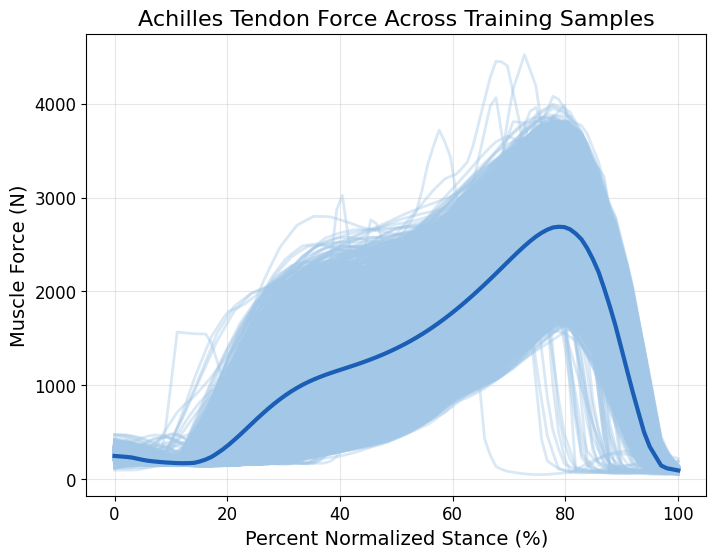

In [4]:
# plot data to double check
plot_achilles_force(y_train)

### Initialize model

In [5]:
model = TransformerModel(input_dim=3, 
                         output_dim=9, 
                         d_model=64, 
                         nhead=4, 
                         num_encoder_layers=4, 
                         dim_feedforward=128, 
                         dropout=0.1)

In [6]:
# define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [7]:
# move the model to the device
model.to(device)

TransformerModel(
  (input_embedding): Linear(in_features=3, out_features=64, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=64, out_features=9, bias=True)
)

### Initialize hyperparameters and data loaders

In [8]:
# hyperparameters
num_epochs = 1000
learning_rate = 1e-3
batch_size = 32

# convert your data to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

# create torch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# create dataloaders from datasets
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

### Train model

In [9]:
best_model, train_hist = train_model(model, train_loader, val_loader, num_epochs=num_epochs, learning_rate=learning_rate, patience=10)

Epoch [1/1000], Train Loss: 261297.1546, Val Loss: 251181.0956
Epoch [10/1000], Train Loss: 26046.5481, Val Loss: 22002.9134
Epoch [20/1000], Train Loss: 3663.7068, Val Loss: 4012.7355
Epoch [30/1000], Train Loss: 2556.8779, Val Loss: 2563.8207
Epoch [40/1000], Train Loss: 2188.8822, Val Loss: 2484.7142
Epoch [50/1000], Train Loss: 1917.4332, Val Loss: 3216.3440
Epoch [60/1000], Train Loss: 1751.2682, Val Loss: 3605.0661
Early stopping at epoch 61


### Test model

In [10]:
test_loss, test_outputs, y_test_tensor = evaluate_model(best_model, X_test, y_test, device=device)

Test Loss: 1960.0134


### Plot sample prediction

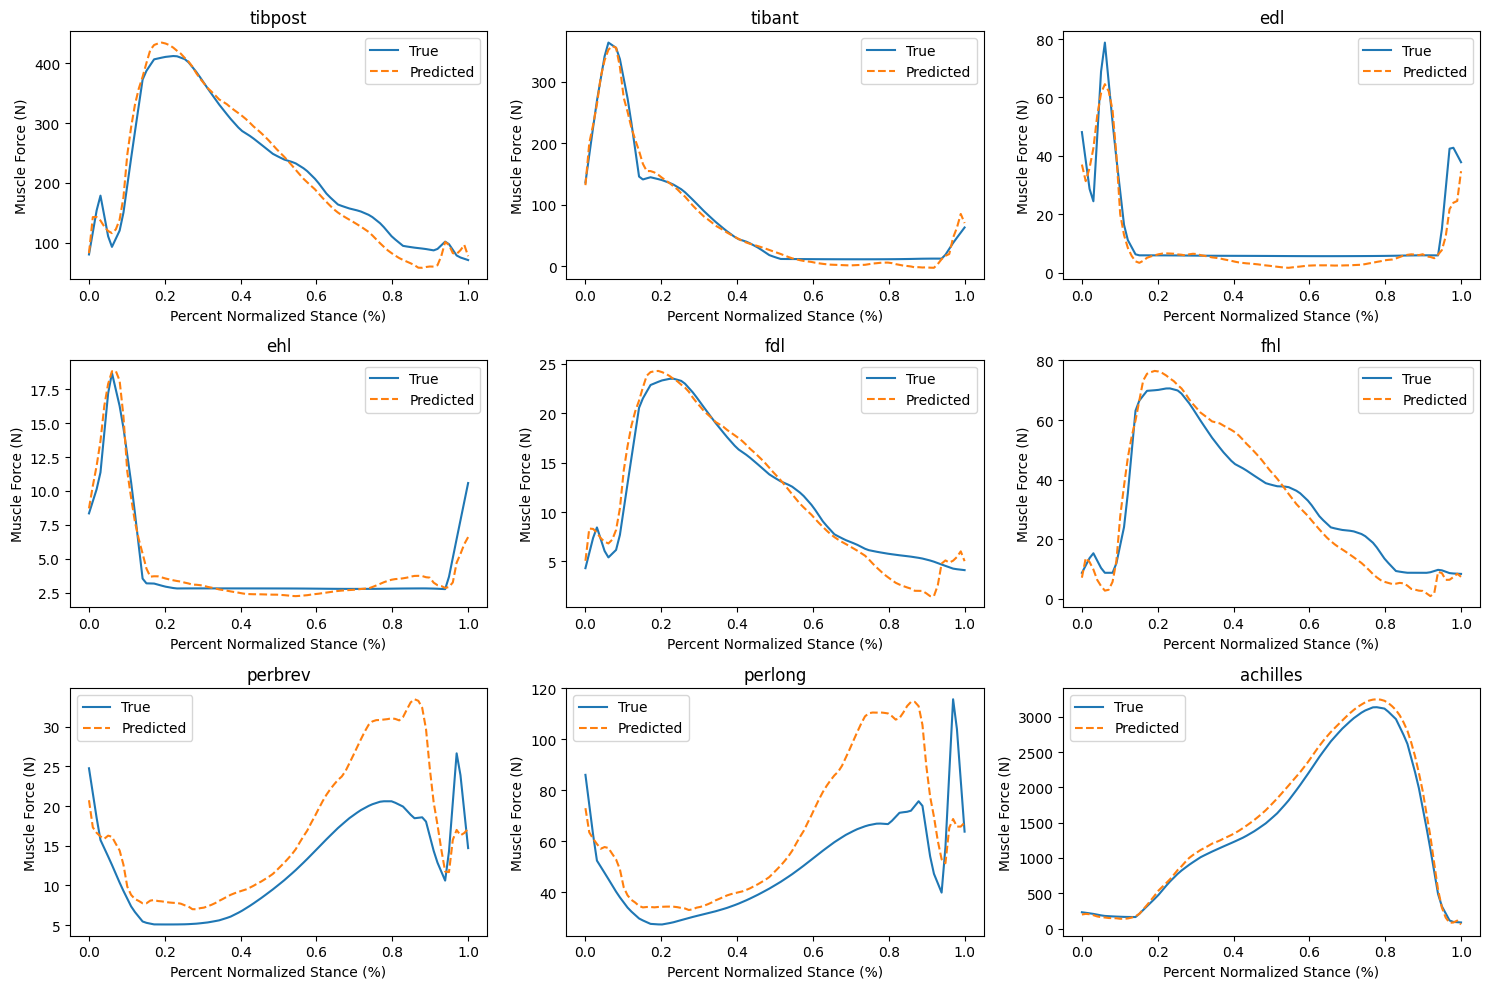

In [11]:
plot_preds(test_outputs, y_test_tensor, sample_idx=0)